In [1]:
!pip install sklearn joblib imbalanced-learn numpy pandas


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'


  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
      More information is available at
      https://github.com/scikit-learn/sklearn-

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
import joblib  # để lưu model
from imblearn.over_sampling import SMOTE
from tqdm import tqdm


In [3]:

df = pd.read_csv(r"merged.csv")
X = df.drop(columns=["id", "Bloom_Label"])
y = df["Bloom_Label"]

# ⚖️ Cân bằng dữ liệu bằng SMOTE
# smote = SMOTE(random_state=42, k_neighbors=5)  # k_neighbors=1 vì có lớp chỉ có 3 mẫu
# X_resampled, y_resampled = smote.fit_resample(X, y)
X_resampled, y_resampled = X, y
# Kiểm tra số lượng mẫu trong từng class
class_counts = y_resampled.value_counts()
print("📊 Số lượng mẫu sau SMOTE:\n", class_counts)


# Trọng số feature
weights = {
    "mean_sim": 2.0,
    "max_sim": 2.0,
    "min_sim": 2.0,
    "std_sim": 2.0,
    "range_sim": 2.0,
    "sentence_length": 1,
    "avg_word_length": 1,
    "num_clauses": 1.5,
    "num_punct": 0,
    "num_nouns": 1.2,
    "num_verbs": 1.2,
    "num_adjs": 1.2,
    "num_lit_terms": 1.5,
    "perplexity": 2.0
}
# Nhân trọng số (sau khi SMOTE)
for col, w in weights.items():
    if col in X_resampled.columns:
        X_resampled[col] = X_resampled[col] * w
scaler = StandardScaler()
X_resampled = pd.DataFrame(scaler.fit_transform(X_resampled), columns=X_resampled.columns)


📊 Số lượng mẫu sau SMOTE:
 Bloom_Label
Understand    1763
Remember       674
Create         263
Analyze        146
Apply          126
Evaluate       106
Name: count, dtype: int64


In [4]:
# 📌 Chia dữ liệu 70% train, 20% val, 10% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
)
# từ 30% chia tiếp: val = 20%, test = 10% → test_size = 10 / (20+10) = 1/3
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=1/3, random_state=42, stratify=y_temp
)
print(f"📊 Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

📊 Train: 2154, Val: 616, Test: 308


In [5]:
# Định nghĩa các tham số cần thử
param_grid = {
    "n_estimators": [500, 600,700],         # số cây
    "max_depth": [None, 20, 30],         # độ sâu tối đa
    "min_samples_split": [4, 5, 7],         # số mẫu tối thiểu để split
    "max_features": ["sqrt", "log2",None],        # số feature dùng khi split
    "class_weight": [None, "balanced"]       # cân bằng dữ liệu hay không
}
rf = RandomForestClassifier(random_state= 20)
param_list = list(ParameterGrid(param_grid))

best_score = -1
best_params = None
best_model = None

print("🚀 Bắt đầu training...\n")

# GridSearchCV
# grid_search = GridSearchCV(
#     estimator=rf,
#     param_grid=param_grid,
#     cv= 10,               # 5-fold cross-validation
#     n_jobs=-1,          # chạy song song nhiều CPU core
#     verbose=3,
#     scoring="f1_macro"  # có thể đổi sang "f1_macro" nếu dữ liệu mất cân bằng
# )
# grid_search.fit(X_train, y_train)

for i, params in enumerate(tqdm(param_list, desc="Training Progress")):
    model = RandomForestClassifier(**params, random_state=20, n_jobs=-1)
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    
    # Dùng F1-macro thay vì accuracy
    score = f1_score(y_val, y_val_pred, average='macro')
    
    if score > best_score:
        best_score = score
        best_params = params
        best_model = model

print("\n🏆 Tham số tốt nhất:", best_params)
print("🏆 F1-macro trên tập validation:", best_score)
# Lưu model tốt nhất
joblib.dump(best_model, "best_random_forest_model.pkl")
print("💾 Model đã được lưu vào 'best_random_forest_model.pkl'")
# print("Best Parameters:", grid_search.best_params_)
# print("Best CV Accuracy:", grid_search.best_score_)

# Dùng model tốt nhất để test
# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# print("Test Accuracy:", accuracy_score(y_test, y_pred))
# print("\nBáo cáo phân loại:\n", classification_report(y_test, y_pred))
# clf.fit(X_train, y_train)
# # Dự đoán
# y_pred = clf.predict(X_test)
# # Đánh giá mô hình
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("\nBáo cáo phân loại:\n", classification_report(y_test, y_pred))




🚀 Bắt đầu training...



Training Progress: 100%|██████████| 162/162 [12:51<00:00,  4.76s/it]



🏆 Tham số tốt nhất: {'class_weight': None, 'max_depth': None, 'max_features': None, 'min_samples_split': 4, 'n_estimators': 700}
🏆 F1-macro trên tập validation: 0.6720853695181668
💾 Model đã được lưu vào 'best_random_forest_model.pkl'


In [6]:
# ===============================
# 🧪 8. Đánh giá trên tập test
# ===============================
y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')

print("\n✅ Hiệu năng trên tập test:")
print(f"Accuracy: {acc:.4f}")
print(f"F1-macro: {f1:.4f}")
print("\n📄 Báo cáo chi tiết:\n", classification_report(y_test, y_pred, digits=3))


✅ Hiệu năng trên tập test:
Accuracy: 0.7987
F1-macro: 0.6724

📄 Báo cáo chi tiết:
               precision    recall  f1-score   support

     Analyze      1.000     0.267     0.421        15
       Apply      0.786     0.846     0.815        13
      Create      0.909     0.385     0.541        26
    Evaluate      1.000     0.455     0.625        11
    Remember      0.857     0.716     0.780        67
  Understand      0.771     0.955     0.853       176

    accuracy                          0.799       308
   macro avg      0.887     0.604     0.672       308
weighted avg      0.821     0.799     0.780       308



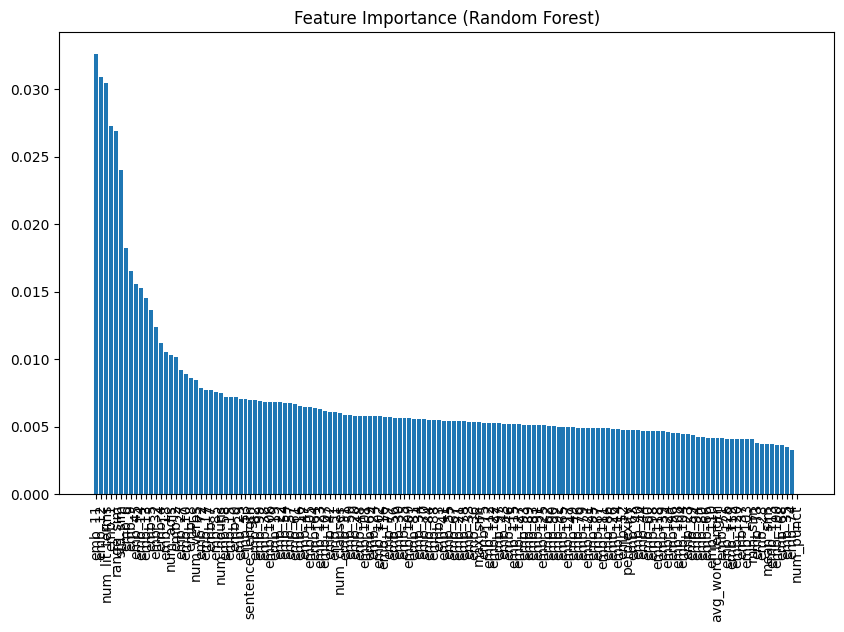

In [7]:
import matplotlib.pyplot as plt
import numpy as np

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.show()

In [8]:
from sklearn.model_selection import cross_validate
import numpy as np

# Đánh giá mô hình với 10-fold CV
cv_results = cross_validate(
    best_model, 
    X, y, 
    cv=10, 
    scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
    n_jobs=-1,
    return_train_score=True
)

# In kết quả trung bình + độ lệch chuẩn
print("\n--- Đánh giá bằng 10-fold Cross-Validation ---")
for metric in ["train_accuracy", "test_accuracy", 
               "train_precision_macro", "test_precision_macro", 
               "train_recall_macro", "test_recall_macro", 
               "train_f1_macro", "test_f1_macro"]:
    mean_score = np.mean(cv_results[metric])
    std_score = np.std(cv_results[metric])
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")


--- Đánh giá bằng 10-fold Cross-Validation ---
train_accuracy: 1.0000 ± 0.0001
test_accuracy: 0.6888 ± 0.0310
train_precision_macro: 1.0000 ± 0.0000
test_precision_macro: 0.7544 ± 0.0887
train_recall_macro: 0.9999 ± 0.0002
test_recall_macro: 0.4584 ± 0.0576
train_f1_macro: 1.0000 ± 0.0001
test_f1_macro: 0.4986 ± 0.0695
